### Algorithm implemented :
* Cluster based anomaly detection (K-mean)
* Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories   separately
* Isolation Forest
* One class SVM
* RNN (comparison between prediction and reality)

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline

`import numpy as np`: Imports the NumPy library for **numerical computation and multi-dimentional array operation**.\
`import pandas as pd`: Imports the pandas library for **data manipulation and analysis**.\
`import matplotlib.pyplot as plt`: Imports the pyplot module from the matplotlib library for plotting.\
`from sklearn.preprocessing import StandardScaler`: Imports the StandardScaler class from scikit-learn's preprocessing module for feature scaling.\
`from sklearn.decomposition import PCA`: Imports the PCA (Principal Component Analysis) class from scikit-learn's decomposition module for dimensionality reduction.\
`from sklearn.cluster import KMeans`: Imports the KMeans class from scikit-learn's cluster module for K-means clustering.\
`from sklearn.covariance import EllipticEnvelope`: Imports the EllipticEnvelope class from scikit-learn's covariance module for outlier detection using the Elliptic Envelope method.\
`from sklearn.ensemble import IsolationForest`: Imports the IsolationForest class from scikit-learn's ensemble module for outlier detection using the Isolation Forest method.

In [2]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

**Explanation:**

`def getDistanceByPoint(data, model)`: defines a function named getDistanceByPoint that takes two parameters: data (a DataFrame containing data points) and model (a clustering model, likely KMeans).\
`distance = pd.Series()`: initializes an empty pandas Series called distance to store the distances between data points and their corresponding cluster centers.\
The function then iterates through each data point using a for loop.\
`Xa = np.array(data.loc[i])` extracts the features of the current data point and converts them into a NumPy array (Xa).\
`Xb = model.cluster_centers_[model.labels_[i] - 1]` retrieves the cluster center corresponding to the data point's cluster label.\
`distance.at[i] = np.linalg.norm(Xa - Xb)` calculates the Euclidean distance between the data point and its cluster center using the ``np.linalg.norm`` function and stores it in the distance Series at index i.\
Finally, the function returns the Series containing the distances.

### 1. Data

#### 1.1 Extract Data

In [3]:
df = pd.read_csv('ambient_temperature_system_failure.csv')

**Ambient temperature** refers to the current temperature of the surrounding environment. It is the temperature of the air or surroundings where a particular activity or process is taking place. The term "ambient" signifies the temperature of the immediate environment without any specific control or modification.

#### 1.2 Understand data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


`df.info()`: This function is used to display a summary of the DataFrame df. It shows the range of indices (from 0 to 7266 in this case), the total number of columns (2 columns), and details about each column:

Column: The name of the column.\
Non-Null Count: The count of non-null (non-missing) entries in that column.\
Dtype: The data type of the values in the column (e.g., float64 for numerical data, object for strings or mixed types).\
In this specific output, we see that the DataFrame has 7267 entries (rows) with 2 columns:

`timestamp`: Contains non-null objects (likely representing timestamps).\
`value`: Contains non-null float64 data (presumably numerical values).
This information is helpful for understanding the structure and characteristics of the dataset.

In [5]:
# Check timestamp format and frequence
df['timestamp'].head()

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
Name: timestamp, dtype: object

In [6]:
# Check the temperature mean
df['value'].mean()

71.24243270828815

<Axes: xlabel='timestamp'>

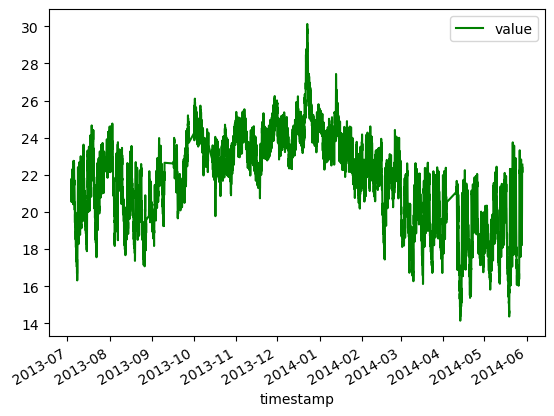

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', color='g')

df['timestamp'] = pd.to_datetime(df['timestamp']): This line converts the 'timestamp' column in the DataFrame df to a datetime format. This is useful for time series analysis and plotting data over time.

df['value'] = (df['value'] - 32) * 5/9: This line converts the temperature values in the 'value' column from Fahrenheit to Celsius. It subtracts 32 from each value (to convert from Fahrenheit to Celsius) and then multiplies the result by 5/9, which is the conversion factor from Fahrenheit to Celsius.

df.plot(x='timestamp', y='value', color='g'): This line creates a basic line plot of the DataFrame df. It uses the 'timestamp' column for the x-axis and the 'value' column (presumably representing temperature in Celsius after the conversion) for the y-axis. The parameter color='g' sets the color of the plotted line to green

### 1.3 Feature Engineering
Extracting useful features

In [8]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

`df['hours'] = df['timestamp'].dt.hour`: This line extracts the hour component from the 'timestamp' column and stores it in a new 'hours' column in the DataFrame.

`df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)`: Here, a new column 'daylight' is created to indicate whether the hour is within the daylight hours (from 7 AM to 10 PM). It uses boolean conditions to check if the 'hours' fall within this range and converts the resulting boolean values to integers (0 or 1).

`df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek`: This line extracts the day of the week (0 for Monday, 6 for Sunday) from the 'timestamp' column and adds this information to a new 'DayOfTheWeek' column.

`df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)`: It creates a new column 'WeekDay' that indicates whether the day falls on a weekday (Monday to Friday) or not. It uses a condition to check if 'DayOfTheWeek' is less than 5 (indicating a weekday) and converts the result to integers (0 or 1).

In [9]:
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [10]:
df['time_epoch'] = (df['timestamp'].astype(np.int64) / 100000000000).astype(np.int64) 

`/ 100000000000` divides the nanoseconds by 10^11 (100 billion). This likely converts the time to a smaller unit, such as seconds, depending on the original unit of the timestamp.\
The specific reason for dividing by 100 billion depends on the original unit of the timestamp and the desired unit for 'time_epoch'. Without additional context, it's hard to pinpoint the exact rationale.



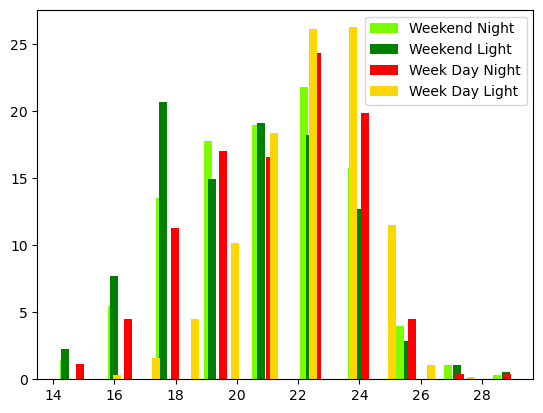

In [11]:
df['categories'] = df['WeekDay']*2 + df['daylight']

# Group the 'value' column based on the 'categories' column
grouped = df.groupby('categories')['value']

# Calculate the heights and bins for each category using the 'groupby' object
heights, bins = [], []
for _, group in grouped:
    h, b = np.histogram(group)
    heights.append(h)
    bins.append(b)

# Plot the bar chart
fig, ax = plt.subplots()
width = (bins[0][1] - bins[0][0]) / 6

colors = ['lawngreen', 'green', 'red', 'gold']
labels = ['Weekend Night', 'Weekend Light', 'Week Day Night', 'Week Day Light']

for i in range(len(heights)):
    ax.bar(bins[i][:-1] + width * i, (heights[i] * 100 / len(grouped.get_group(i))), width=width, facecolor=colors[i], label=labels[i])

plt.legend()
plt.show()

We can see that the temperature is more stable during daylight of business day.



### 2. Model

#### 2.1 Cluster (K-means)

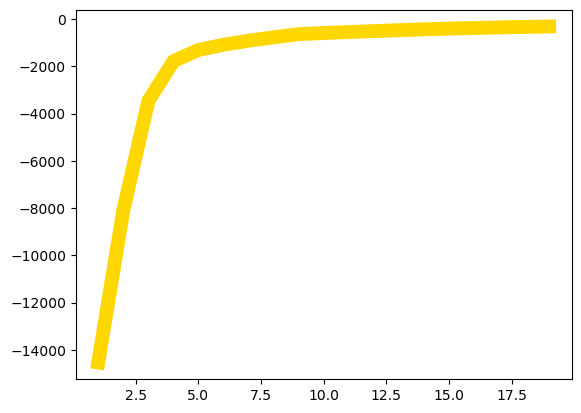

In [12]:
features = ['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay'] 
data = df[features] 

# Standardize and reduce to 2 important features in a single pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])
data = pipeline.fit_transform(data)

# Standardize the 2 new features
min_max_scaler = StandardScaler()
data = min_max_scaler.fit_transform(data)

data = pd.DataFrame(data)


# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores, c='gold', linewidth=10)
plt.show()

In [13]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['PC1'] = data[0]
df['PC2'] = data[1]
df['cluster'].value_counts()

cluster
8     737
13    658
4     610
2     609
14    608
6     599
0     576
9     499
1     432
7     358
5     349
12    347
10    339
11    308
3     238
Name: count, dtype: int64

In [14]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,PC1,PC2
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2,0,0.066191,1.755363
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,0,-0.009413,1.647609
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,0,-0.009359,1.577677
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,0,0.061592,1.543184
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,0,0.031660,1.458262
...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3,2,-0.663130,-0.218870
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3,13,-0.669607,-0.292067
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3,13,-0.679271,-0.366858
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3,13,-0.684664,-0.439514


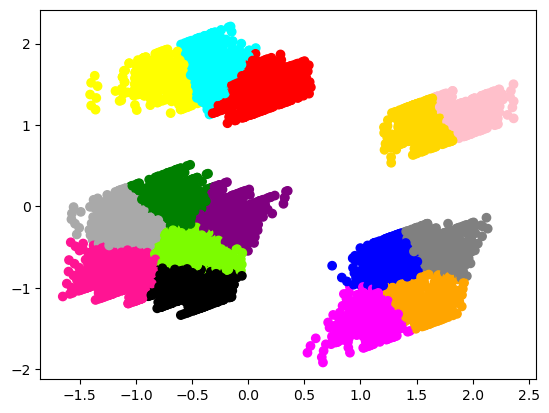

In [15]:
colors = {i: color for i, color in enumerate(['red', 'blue', 'green', 'pink', 'black', 'orange', 'cyan', 'gold', 'deeppink', 'purple', 'magenta', 'grey', 'yellow', 'lawngreen', 'darkgrey'])}
fig, ax = plt.subplots()
ax.scatter(df['PC1'], df['PC2'], c=df["cluster"].map(colors))
plt.show()

In [16]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

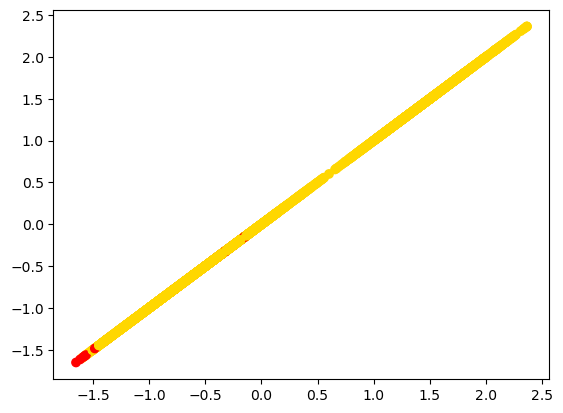

In [17]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'gold', 1:'red'}
ax.scatter(df['PC1'], df['PC1'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

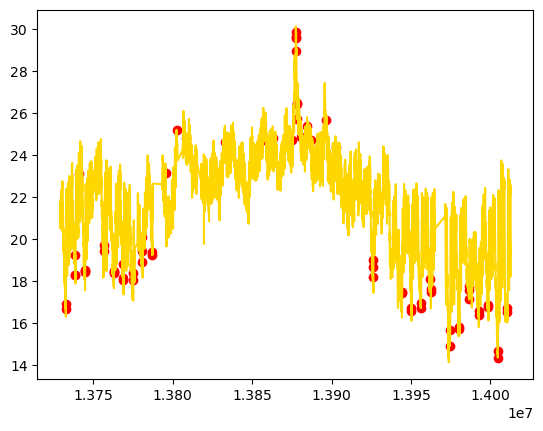

In [18]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='gold')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

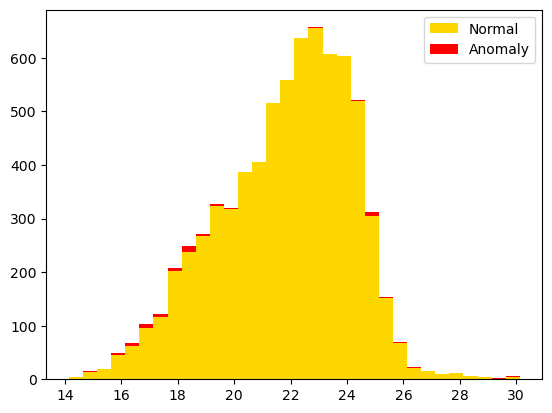

In [19]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['gold', 'red'], label=['Normal', 'Anomaly'])
plt.legend()
plt.show()

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.



### 2.2 Categories + Gaussian

Use for contextual data and collective anomalies (unordered).

We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.



In [20]:
# creation of 4 differents data set based on categories defined before
# df_class0 = df.loc[df['categories'] == 0, 'value']
# df_class1 = df.loc[df['categories'] == 1, 'value']
# df_class2 = df.loc[df['categories'] == 2, 'value']
# df_class3 = df.loc[df['categories'] == 3, 'value']
df_grouped = df.groupby('categories')['value']
df_class0 = df_grouped.get_group(0)
df_class1 = df_grouped.get_group(1)
df_class2 = df_grouped.get_group(2)
df_class3 = df_grouped.get_group(3)

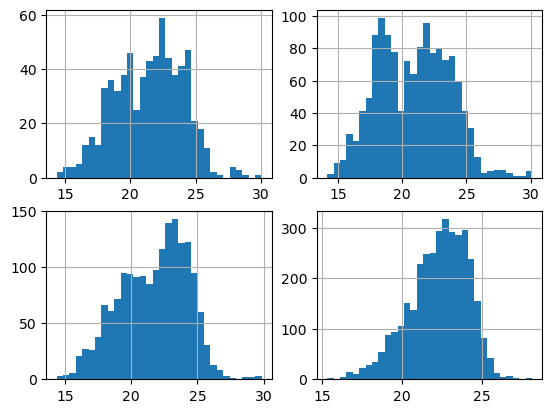

In [21]:
# plot the temperature repartition by categories
# fig, axs = plt.subplots(2,2)
# df_class0.hist(ax=axs[0,0],bins=32)
# df_class1.hist(ax=axs[0,1],bins=32)
# df_class2.hist(ax=axs[1,0],bins=32)
# df_class3.hist(ax=axs[1,1],bins=32)

fig, axs = plt.subplots(2, 2)
classes = [df_class0, df_class1, df_class2, df_class3]
for i, ax in enumerate(axs.flatten()):
    classes[i].hist(ax=ax, bins=32)
plt.show()

In [22]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

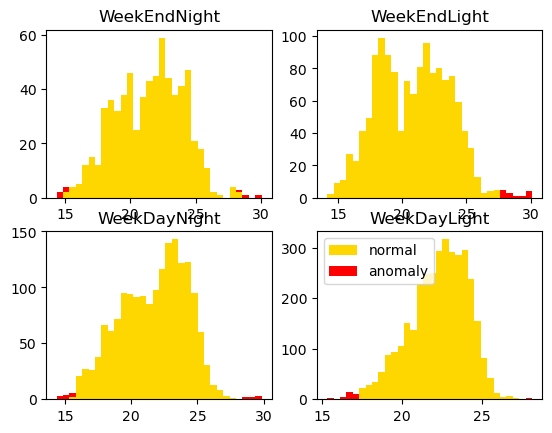

In [23]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['gold', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['gold', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['gold', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['gold', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [24]:
 # add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

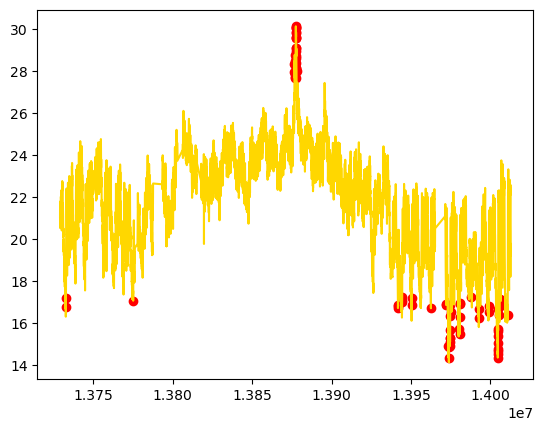

In [25]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='gold')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

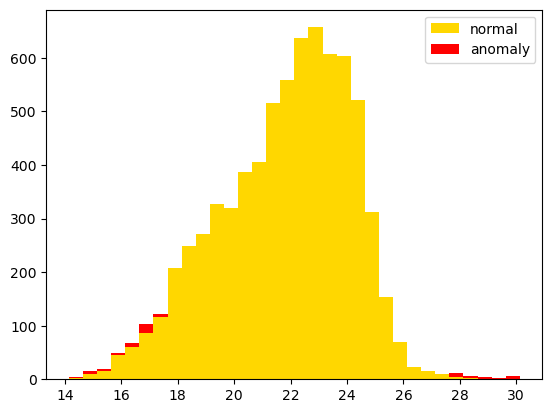

In [26]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['gold', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

### 2.3 Isolation Forest

In [27]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,PC1,PC2,anomaly21,anomaly22
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2,0,0.066191,1.755363,0,0
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,0,-0.009413,1.647609,0,0
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,0,-0.009359,1.577677,0,0
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,0,0.061592,1.543184,0,0
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,0,0.031660,1.458262,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3,2,-0.663130,-0.218870,0,0
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3,13,-0.669607,-0.292067,0,0
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3,13,-0.679271,-0.366858,0,0
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3,13,-0.684664,-0.439514,0,0


In [28]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

anomaly25
0    7194
1      73
Name: count, dtype: int64


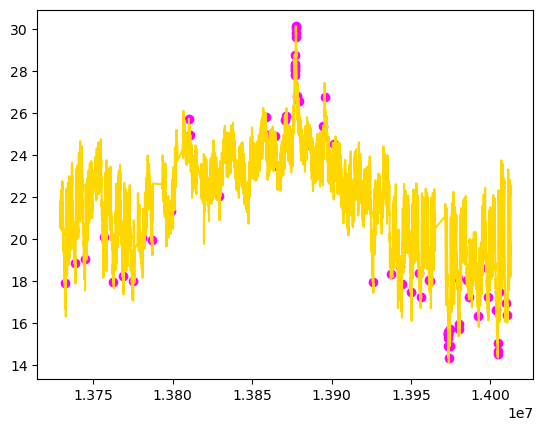

In [29]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='gold')
ax.scatter(a['time_epoch'],a['value'], color='magenta')
plt.show()

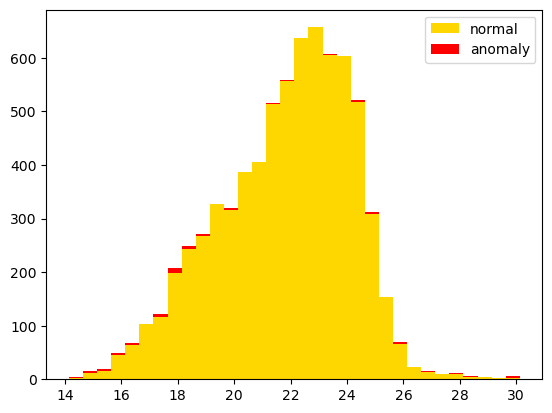

In [30]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['gold', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

### 2.4 One class SVM

In [31]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

anomaly26
0    7198
1      69
Name: count, dtype: int64


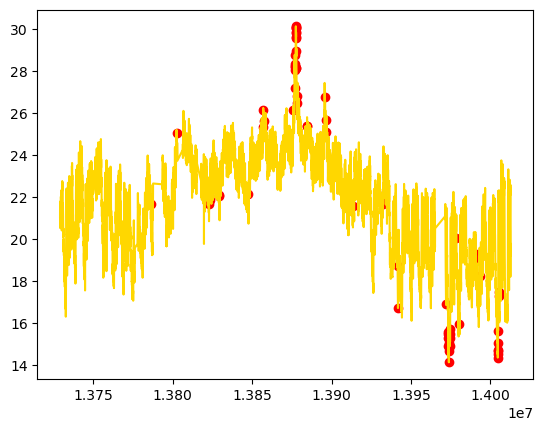

In [32]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='gold')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

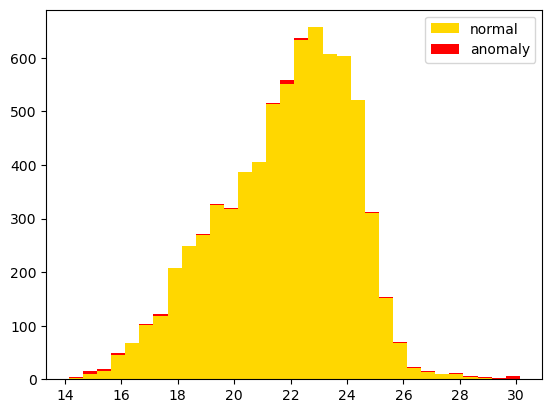

In [33]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['gold', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

### 2.5 RNN
Use for sequential anomalies (ordered)\
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value

In [34]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [35]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [36]:
import sys
import time 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json

In [37]:
# Build the model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.005280017852783203


In [38]:
# Train the model
model.fit(x_train, y_train, batch_size=3028, epochs=30, validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 3s 722ms/step - loss: 0.5146 - val_loss: 0.6509
Epoch 2/30
2/2 [==============================] - 1s 539ms/step - loss: 0.2005 - val_loss: 0.3910
Epoch 3/30
2/2 [==============================] - 1s 552ms/step - loss: 0.1785 - val_loss: 0.3336
Epoch 4/30
2/2 [==============================] - 1s 513ms/step - loss: 0.1145 - val_loss: 0.2706
Epoch 5/30
2/2 [==============================] - 1s 540ms/step - loss: 0.1218 - val_loss: 0.2664
Epoch 6/30
2/2 [==============================] - 1s 509ms/step - loss: 0.1137 - val_loss: 0.2111
Epoch 7/30
2/2 [==============================] - 1s 536ms/step - loss: 0.0966 - val_loss: 0.1901
Epoch 8/30
2/2 [==============================] - 1s 522ms/step - loss: 0.0918 - val_loss: 0.2064
Epoch 9/30
2/2 [==============================] - 1s 509ms/step - loss: 0.0930 - val_loss: 0.1881
Epoch 10/30
2/2 [==============================] - 1s 531ms/step - loss: 0.0897 - val_loss: 0.1655
Epoch 11/30
2/2 [==

In [39]:
# save the model because the training is long (1h30) and we don't want to do it every time

# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")


In [40]:
# load json and create model

# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

32/32 [==============================] - 1s 12ms/step


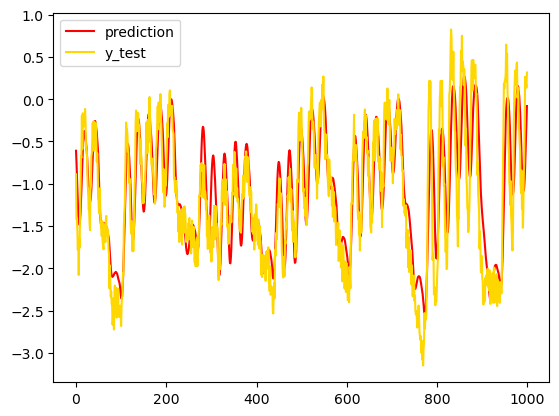

In [41]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='gold', label='y_test')
plt.legend(loc='upper left')
plt.show()


In [42]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = pd.concat([complement, test], ignore_index=True)
print(df['anomaly27'].value_counts())

anomaly27
0    7257
1      10
Name: count, dtype: int64


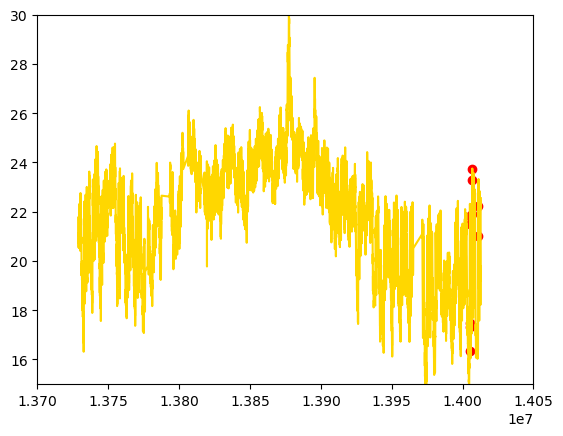

In [43]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='gold')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

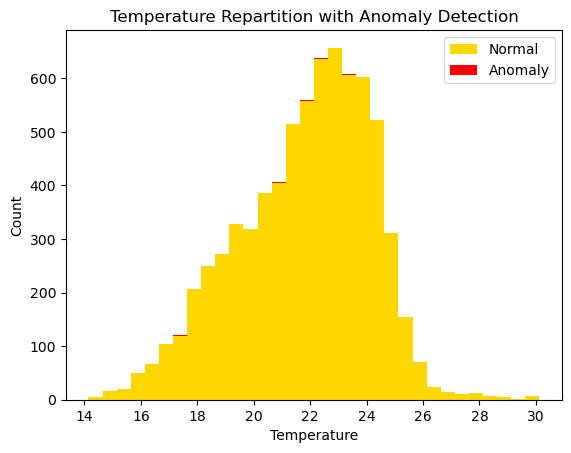

In [44]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['gold', 'red'], label=['Normal', 'Anomaly'])  # Added labels for legend
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Temperature Repartition with Anomaly Detection')
plt.show()